In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [3]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset

from counterfactuals.optimizers.approach_three import ApproachThree
from counterfactuals.utils import plot_model_distribution

from counterfactuals.metrics.metrics import (
    perc_valid_cf,
    perc_valid_actionable_cf,
    continuous_distance,
    categorical_distance,
    distance_l2_jaccard,
    distance_mad_hamming,
    plausibility
)

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

/net/people/plgrid/plgofurman/plgguncflows/counterfactuals/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Moons

## Train model

In [5]:
dataset = MoonsDataset(file_path="../data/moons.csv")
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)


disc_model = LogisticRegression()
disc_model.fit(dataset.X_train, dataset.y_train.reshape(-1))

dataset.y_train = disc_model.predict(dataset.X_train)
dataset.y_test = disc_model.predict(dataset.X_test)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=1e-5)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)

In [6]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
cf = ApproachThree(model=flow)

In [7]:
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=100,
    verbose=True
)

Epochs:   1%|          | 1/100 [00:00<01:34,  1.05it/s]

Epoch 0, Train: 2.137614494794375, test: 1.3597031143995433


Epochs:  11%|█         | 11/100 [00:09<01:17,  1.14it/s]

Epoch 10, Train: 0.41150157308423674, test: 0.38359851791308475


Epochs:  21%|██        | 21/100 [00:18<01:07,  1.16it/s]

Epoch 20, Train: 0.40108432875567185, test: 0.3619806365324901


Epochs:  31%|███       | 31/100 [00:26<00:59,  1.17it/s]

Epoch 30, Train: 0.3979361236934022, test: 0.36750917595166427


Epochs:  41%|████      | 41/100 [00:35<00:51,  1.14it/s]

Epoch 40, Train: 0.3808381977406415, test: 0.35256346143209016


Epochs:  51%|█████     | 51/100 [00:44<00:42,  1.15it/s]

Epoch 50, Train: 0.372011189143379, test: 0.3399317545386461


Epochs:  61%|██████    | 61/100 [00:53<00:34,  1.13it/s]

Epoch 60, Train: 0.36521152268240464, test: 0.3489550810593825


Epochs:  71%|███████   | 71/100 [01:01<00:25,  1.13it/s]

Epoch 70, Train: 0.3724483215770164, test: 0.3610877887560771


Epochs:  81%|████████  | 81/100 [01:10<00:17,  1.11it/s]

Epoch 80, Train: 0.35964421695703036, test: 0.3326881854579999


Epochs:  91%|█████████ | 91/100 [01:19<00:08,  1.12it/s]

Epoch 90, Train: 0.3594414833691213, test: 0.34789229241701275


Epochs: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


In [8]:
cf.test_model(test_loader=test_dataloader)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       797
         1.0       1.00      1.00      1.00       842

    accuracy                           1.00      1639
   macro avg       1.00      1.00      1.00      1639
weighted avg       1.00      1.00      1.00      1639



## Generate counterfactuals

In [ ]:
cf.search_batch(test_dataloader, epochs=200, lr=1e-3, alpha=20, beta=0.01)

In [9]:
Xs_cfs = cf.generate_counterfactuals(Xs=dataset.X_test[:100], ys=dataset.y_test[:100], num_epochs=100, lr=0.005, alpha=20, beta=0.01)
Xs_cfs = torch.concat(Xs_cfs).detach()

0it [00:00, ?it/s]

100it [01:01,  1.64it/s]


/net/people/plgrid/plgofurman/plgguncflows/counterfactuals/venv/lib64/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


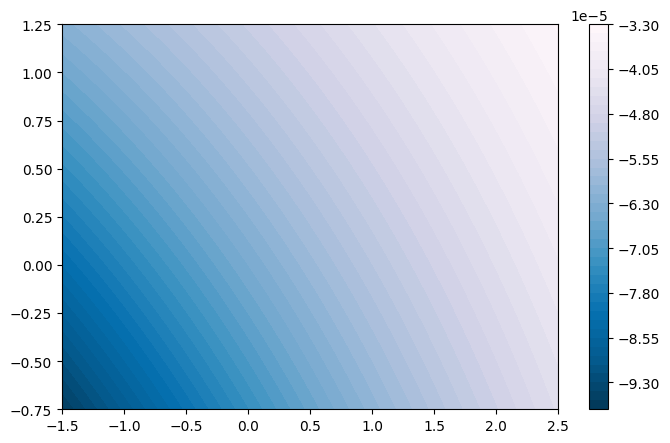

In [7]:
plot_model_distribution(cf.model)

## Scores

### CF Metrics for Flow predictions

In [10]:
ys_cfs_pred = cf.predict_model(Xs_cfs)
ys_orig_pred = cf.predict_model(dataset.X_test[:100])
ys_orig = dataset.y_test[:100].flatten()

{
    "valid_cf": perc_valid_cf(ys_orig_pred, y_cf=ys_cfs_pred),
    "valid_cf_for_orig_data": perc_valid_cf(ys_orig, y_cf=ys_cfs_pred),
    # "perc_valid_actionable_cf": perc_valid_actionable_cf(X=dataset.X_test, X_cf=Xs_cfs, y=ys_orig_pred, y_cf=ys_cfs_pred, actionable_features=[0])
}

{'valid_cf': 0.82, 'valid_cf_for_orig_data': 0.82}

# HELOC

## Train Model

In [11]:
dataset = HelocDataset(file_path="../data/origin/heloc.csv")
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [12]:
flow = MaskedAutoregressiveFlow(features=23, hidden_features=4, context_features=1)
cf = ApproachThree(model=flow)
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=100,
    verbose=True
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   1%|          | 1/100 [00:00<00:59,  1.66it/s]

Epoch 0, Train: 35.74931222985725, test: -4.211443018387346


Epochs:  11%|█         | 11/100 [00:06<00:53,  1.68it/s]

Epoch 10, Train: -24.643653470116693, test: -24.520546296063593


Epochs:  21%|██        | 21/100 [00:12<00:47,  1.68it/s]

Epoch 20, Train: -26.38850231428404, test: -26.427336300120633


Epochs:  31%|███       | 31/100 [00:18<00:40,  1.69it/s]

Epoch 30, Train: -27.363692399617786, test: -27.42388691621668


Epochs:  41%|████      | 41/100 [00:24<00:34,  1.70it/s]

Epoch 40, Train: -27.833121402843577, test: -27.008918537813074


Epochs:  51%|█████     | 51/100 [00:30<00:29,  1.67it/s]

Epoch 50, Train: -28.66521644592285, test: -28.458062115837546


Epochs:  61%|██████    | 61/100 [00:36<00:22,  1.70it/s]

Epoch 60, Train: -29.34364401327597, test: -29.277825636022232


Epochs:  71%|███████   | 71/100 [00:42<00:17,  1.70it/s]

Epoch 70, Train: -30.06408018679232, test: -30.155681161319507


Epochs:  81%|████████  | 81/100 [00:48<00:11,  1.71it/s]

Epoch 80, Train: -31.760069228507376, test: -31.770806032068588


Epochs:  91%|█████████ | 91/100 [00:53<00:05,  1.71it/s]

Epoch 90, Train: -33.34506137951, test: -33.29686523886288


Epochs: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


In [13]:
cf.test_model(test_loader=test_dataloader)

              precision    recall  f1-score   support

         0.0       0.71      0.60      0.65       556
         1.0       0.61      0.72      0.66       490

    accuracy                           0.66      1046
   macro avg       0.66      0.66      0.66      1046
weighted avg       0.66      0.66      0.66      1046



## Generate counterfactuals

In [14]:
Xs_cfs = cf.generate_counterfactuals(Xs=dataset.X_test[:100], ys=dataset.y_test[:100], num_epochs=100, lr=0.005, alpha=20, beta=0.01)
Xs_cfs = torch.concat(Xs_cfs).detach().numpy()

0it [00:00, ?it/s]

100it [01:01,  1.63it/s]


## Scores

In [46]:
X = dataset.X_test[:100]
ys_cfs_pred = cf.predict_model(Xs_cfs)
ys_orig_pred = cf.predict_model(dataset.X_test[:100])
ys_orig = dataset.y_test[:100].flatten()

{
    "valid_cf": perc_valid_cf(ys_orig_pred, y_cf=ys_cfs_pred),
    "valid_cf_for_orig_data": perc_valid_cf(ys_orig, y_cf=ys_cfs_pred),
    "perc_valid_actionable_cf": perc_valid_actionable_cf(X=dataset.X_test[:100], X_cf=Xs_cfs, y=ys_orig_pred, y_cf=ys_cfs_pred, actionable_features=[1,2]),
    "cont_dist": continuous_distance(X=X, X_cf=Xs_cfs, continuous_features=[0,1,2,3], metric='mad', X_all=dataset.X_test),
    "cat_dist": categorical_distance(X=X, X_cf=Xs_cfs, categorical_features=[4,5,6,7,8,9], metric='jaccard', agg='mean'),
    "distance_l2_jaccard": distance_l2_jaccard(X=X, X_cf=Xs_cfs, continuous_features=[0,1,2,3], categorical_features=[4,5,6,7,8,9]),
    "distance_mad_hamming": distance_mad_hamming(X=X, X_cf=Xs_cfs, continuous_features=[0,1,2,3], categorical_features=[4,5,6,7,8,9], X_all=X, agg='mean'),
    "plausibility": plausibility(X, Xs_cfs, ys_orig, continuous_features_all=[0,1,2,3], categorical_features_all=[4,5,6,7,8,9], X_train=dataset.X_train, ratio_cont=None)
}

{'valid_cf': 0.65,
 'valid_cf_for_orig_data': 1.0,
 'perc_valid_actionable_cf': 0.0,
 'cont_dist': 1.9591286355257034,
 'cat_dist': 0.65,
 'distance_l2_jaccard': 0.17664673292815372,
 'distance_mad_hamming': 0.5723472670886827,
 'plausibility': 0.8041791783208432}

# LAW

## Train model

In [52]:
dataset = LawDataset(file_path="../data/origin/law.csv")
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)

In [53]:
flow = MaskedAutoregressiveFlow(features=3, hidden_features=4, context_features=1)
cf = ApproachThree(model=flow)
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=100,
    verbose=True
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   3%|▎         | 3/100 [00:00<00:09, 10.03it/s]

Epoch 0, Train: 9.223700612783432, test: 8.432320356369019


Epochs:  13%|█▎        | 13/100 [00:01<00:08, 10.24it/s]

Epoch 10, Train: -1.1231051646173, test: -1.1089640259742737


Epochs:  23%|██▎       | 23/100 [00:02<00:07, 10.39it/s]

Epoch 20, Train: -1.1938231848180294, test: -1.150842159986496


Epochs:  33%|███▎      | 33/100 [00:03<00:06, 10.30it/s]

Epoch 30, Train: -1.2223271373659372, test: -1.1551081836223602


Epochs:  43%|████▎     | 43/100 [00:04<00:05, 10.35it/s]

Epoch 40, Train: -1.224856872111559, test: -1.1615441739559174


Epochs:  53%|█████▎    | 53/100 [00:05<00:04, 10.44it/s]

Epoch 50, Train: -1.219818040728569, test: -1.1669879257678986


Epochs:  63%|██████▎   | 63/100 [00:06<00:03, 10.31it/s]

Epoch 60, Train: -1.2211038935929537, test: -1.1531431078910828


Epochs:  73%|███████▎  | 73/100 [00:07<00:02, 10.38it/s]

Epoch 70, Train: -1.2277605552226305, test: -1.1732704937458038


Epochs:  83%|████████▎ | 83/100 [00:08<00:01, 10.43it/s]

Epoch 80, Train: -1.2253996096551418, test: -1.1545093953609467


Epochs:  93%|█████████▎| 93/100 [00:09<00:00, 10.42it/s]

Epoch 90, Train: -1.2172787114977837, test: -1.1657378375530243


Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


In [54]:
cf.test_model(test_loader=test_dataloader)

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73       107
         1.0       0.77      0.66      0.71       115

    accuracy                           0.72       222
   macro avg       0.73      0.72      0.72       222
weighted avg       0.73      0.72      0.72       222



## Generate counterfactuals

In [55]:
Xs_cfs = cf.generate_counterfactuals(Xs=dataset.X_test[:100], ys=dataset.y_test[:100], num_epochs=100, lr=0.005, alpha=20, beta=0.01)
Xs_cfs = torch.concat(Xs_cfs).detach()

100it [00:46,  2.15it/s]


## Score

In [56]:
logr = LogisticRegression()
logr.fit(dataset.X_train, dataset.y_train)
y_pred_logr = logr.predict(dataset.X_test)
print(classification_report(dataset.y_test, y_pred_logr, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73       107
         1.0       0.77      0.66      0.71       115

    accuracy                           0.72       222
   macro avg       0.73      0.72      0.72       222
weighted avg       0.73      0.72      0.72       222



In [57]:
mlpc = MLPClassifier((128, 64), max_iter=50)
mlpc.fit(dataset.X_train, dataset.y_train)
y_pred_mlpc = mlpc.predict(dataset.X_test)
print(classification_report(dataset.y_test, y_pred_mlpc, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.68      0.80      0.74       107
         1.0       0.78      0.65      0.71       115

    accuracy                           0.73       222
   macro avg       0.73      0.73      0.72       222
weighted avg       0.73      0.73      0.72       222



In [58]:
ys_cfs_pred = cf.predict_model(Xs_cfs)
ys_orig_pred = cf.predict_model(dataset.X_test[:100])

validity(ys_cfs_pred, ys_orig_pred)

0.69

In [59]:
y_cfs_pred_logr = logr.predict(Xs_cfs)
y_orig_pred_logr = logr.predict(dataset.X_test[:100])

validity(y_cfs_pred_logr, y_orig_pred_logr)

0.68

In [60]:
y_cfs_pred_mlpc = mlpc.predict(Xs_cfs)
y_orig_pred_mlpc = mlpc.predict(dataset.X_test[:100])

np.sum(y_cfs_pred_mlpc != y_orig_pred_mlpc) / y_orig_pred_mlpc.shape[0]

0.67